# Fraud Transaction Detection using Machine Learning

## Objective
The objective of this project is to build a machine learning model that can predict fraudulent transactions for a financial company and to derive meaningful business insights that can help
in preventing fraud.


In [1]:
# 1: IMPORT REQUIRED LIBRABRIES 
# Basic data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


## Step 1: Import Libraries
We import the required Python libraries:
1. **pandas** → To load and look at the transaction data, check balances, amounts, types, and spot frauds.

2. **numpy** → To do math on numbers, like differences in balances or scaling amounts.

3. **matplotlib.pyplot** → To draw charts and graphs to see patterns in the data.

4. **seaborn** → To make charts nicer and easier to understand, like showing fraud vs non-fraud.

5. **sklearn.model_selection** → To split the data into training and testing sets for building and checking models.

6. **sklearn.preprocessing** → To scale numbers like amounts and balances so models work better.

7. **sklearn.linear_model** → Logistic Regression is a simple model to predict fraud and see which features matter.

8. **sklearn.ensemble** → Random Forest is a stronger model to catch fraud using patterns in the data.

9. **sklearn.metrics** → To check how good our model is at detecting fraud.

10. **warnings** → To hide extra messages and keep the notebook clean.

In [2]:
#2. LOAD THE DATASET
df = pd.read_csv("Fraud.csv")
# Show first 5 rows
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
#3. UNDERSTAND DATASET
# 3A:  CHECK THE DATASET SHAPE
print('DATA SHAPE:',df.shape)
#3B : UNDERSTAND THE SUMMARY OF THE DATASET
print('\nDATA INFORMATION:',df.info())
# 3C:  CHECK DISTRIBUTION OF FRAUD VS NON-FRAUD
print('\nFRAUD COUNTS:',df['isFraud'].value_counts())

DATA SHAPE: (6362620, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB

DATA INFORMATION: None

FRAUD COUNTS: isFraud
0    6354407
1       8213
Name: count, dtype: int64


# Step 3: Understand the Dataset

Before we start building a fraud detection model, it is important to **understand the dataset**. 

## 3A:  Check Dataset Shape (`df.shape`)
   - Shows the number of rows and columns.  
   - Helps us understand the size of the dataset (over 6 million transactions here) and plan memory/processing needs.
## 3B:  Check Dataset Summary (`df.info()`)
   - Displays column names, data types, and non-null counts.  
   - Helps us identify numerical vs categorical columns and check for **missing values**.

## 3C : Check Distribution of Fraud vs Non-Fraud (`df['isFraud'].value_counts()`)  
   - Shows how many transactions are fraudulent and non-fraudulent.  
   - Important because the dataset is **highly imbalanced**, which will affect model evaluation.

- Most transactions are legitimate (`isFraud = 0`)
- Only a small percentage are fraudulent (`isFraud = 1`)

This imbalance is typical in fraud detection and needs careful evaluation using metrics
like precision, recall, and ROC-AUC, not just accuracy.


No. of missing values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
amount_log        0
dtype: int64


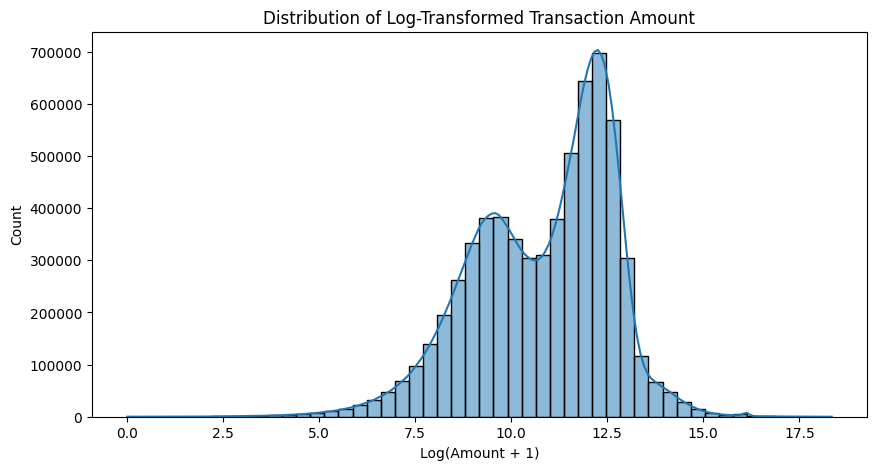

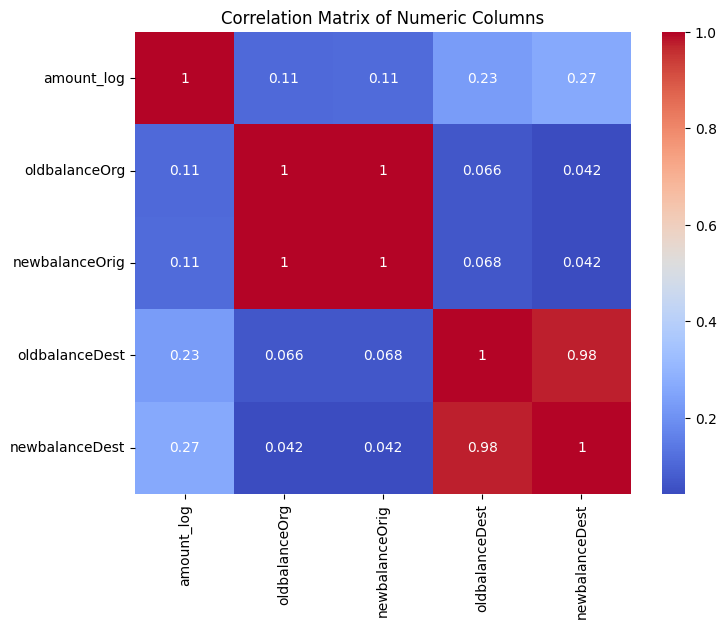

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,amount_log,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9.194276,False,False,True,False
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,7.531166,False,False,True,False
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,5.204007,False,False,False,True
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,5.204007,True,False,False,False
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,9.364703,False,False,True,False


In [5]:
# 4. DATA CLEANING

# 4A. CHECK FOR MISSING VALUES
print('No. of missing values:\n',df.isnull().sum())


# 4B. DETECT OUTLIERS
# Select numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Create dictionary to store outlier counts per column
outlier_counts = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    # Count outliers
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
    outlier_counts[col] = outliers.shape[0]

# Convert to dataframe for easy viewing
outlier_df = pd.DataFrame(list(outlier_counts.items()), columns=['Column', 'Num_Outliers'])
outlier_df

# 4C. HANDLE OUTLIER 
# Log-transform 'amount' to handle outliers
df['amount_log'] = np.log1p(df['amount'])  # log1p handles zero values safely

# Check distribution after transformation
plt.figure(figsize=(10,5))
sns.histplot(df['amount_log'], bins=50, kde=True)
plt.title("Distribution of Log-Transformed Transaction Amount")
plt.xlabel("Log(Amount + 1)")
plt.show()

# 4C. HANDLE MULTICOLLINEARITY
# Compute correlation matrix for numeric columns
corr_matrix = df[['amount_log', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].corr()

# Visualize correlation
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Numeric Columns")
plt.show()

# Drop highly correlated column for linear models
df_model = df.drop(['newbalanceOrig'], axis=1)


# 4D. ENCODE CATEGORICAL VARIABLES 
# One-hot encode 'type'
df_encoded = pd.get_dummies(df, columns=['type'], drop_first=True)  # drop_first avoids dummy variable trap

# Check first 5 rows
df_encoded.head()


# Step 4: Data Cleaning

## 4A. Check for Missing Values
We first checked if any data is missing using `df.isnull().sum()`.  

There are **no missing values**, so no imputation is needed.

## 4B. Detect Outliers
Outliers are extreme values that can skew the model.  

We checked all numeric columns using the **IQR method**.  

Many columns have outliers, but **`amount` is the most important for fraud detection**, so we focus on it.

## 4C. Handle Outliers
We applied a **log transformation** to `amount` using `np.log1p`.  

- This reduces the effect of extremely high transactions and makes the data more suitable for modeling.  
- Other numeric columns (balances) are kept as-is because they are naturally high/low and **tree-based models can handle them**.

## 4D. Handle Multicollinearity
Some numeric columns are highly correlated (e.g., `oldbalanceOrg` and `newbalanceOrig`).  

- High correlation can affect **linear models**, so we optionally drop `newbalanceOrig`.  
- **Tree-based models** (Random Forest, XGBoost) do not require dropping correlated columns.

## 4E. Encode Categorical Variables


The **type** column is a categorical feature (e.g., CASH-IN, CASH-OUT, TRANSFER).

Machine learning models **cannot work directly with text values**.  
They require **numerical input** to perform mathematical calculations such as splits, distance, and probability estimation.

Therefore:
- We use **one-hot encoding** to convert each transaction type into separate binary (0/1) columns.
- Each encoded column represents the presence or absence of a specific transaction type.

The parameter `drop_first=True` is used to:
- Avoid redundant information (dummy variable trap)
- Reduce multicollinearity for linear models
- Improve model efficiency

After encoding, all features are numeric and compatible with machine learning algorithms.



In [6]:
# 5A. FEATURE SELECTION

# Drop identifier columns
df_model = df_encoded.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)

print("Columns used for modeling:")
df_model.columns

Columns used for modeling:


Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'amount_log', 'type_CASH_OUT',
       'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')

In [7]:
# 5B. STRATIFIED SAMPLING 

# Take a stratified 3M-row sample from the full dataset
df_sample_3m = df_model.groupby('isFraud', group_keys=False).apply(
    lambda x: x.sample(frac=3_000_000/len(df_model), random_state=42)
)

print("Sampled dataset shape:", df_sample_3m.shape)
print(df_sample_3m['isFraud'].value_counts(normalize=True))

# Separate Features and Target
X = df_sample_3m.drop('isFraud', axis=1)
y = df_sample_3m['isFraud']

# Stratified Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)


Sampled dataset shape: (3000000, 12)
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64
Training set: (2400000, 11)
Testing set: (600000, 11)


In [8]:
#5C. MODEL BUILDING(RANDOM FOREST, OPTIMIZED)
rf_model_3m = RandomForestClassifier(
    n_estimators=30,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Train
rf_model_3m.fit(X_train, y_train)

# Predictions
y_pred = rf_model_3m.predict(X_test)
y_pred_prob = rf_model_3m.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    599226
           1       0.09      0.98      0.16       774

    accuracy                           0.99    600000
   macro avg       0.54      0.99      0.58    600000
weighted avg       1.00      0.99      0.99    600000

ROC-AUC Score: 0.9974857273031217


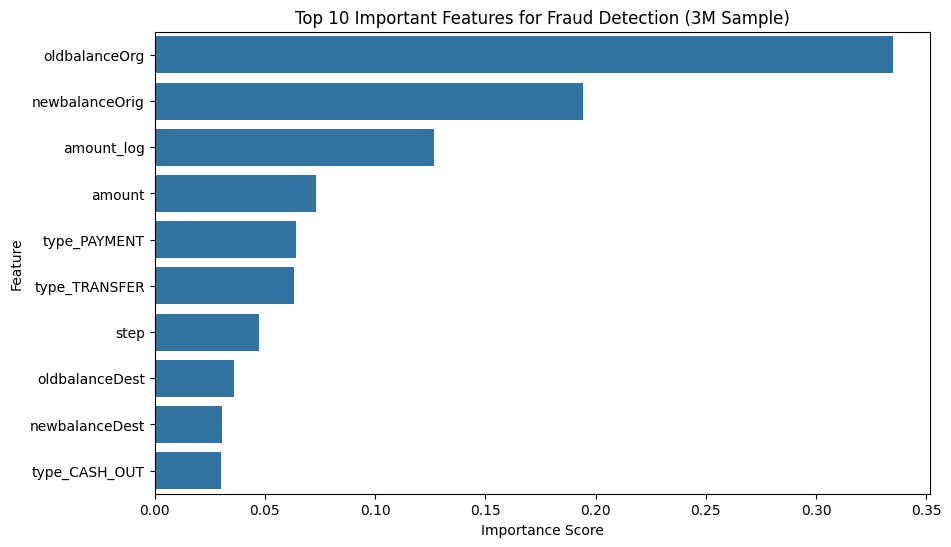

In [9]:
# 5D. FEATURE IMPORTANCE 
importances = pd.Series(rf_model_3m.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importances[:10], y=importances.index[:10])
plt.title("Top 10 Important Features for Fraud Detection (3M Sample)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()



## Step 5: Feature Selection and Model Building (3M-row Sample)

### 5A. Feature Selection
Identifier columns like `nameOrig` and `nameDest` do not provide useful information for predicting fraud and may introduce noise. Therefore, these columns, along with `isFlaggedFraud`, are removed.  
The target variable is `isFraud`, and all remaining columns are used as features for modeling.

### 5B. Stratified Sampling & Train-Test Split
The dataset is very large and highly imbalanced (fraud cases are rare). To reduce training time while maintaining representative fraud examples, we take a **stratified 3M-row sample** of the dataset.  
The sampled data is then split into training (80%) and testing (20%) sets using **stratified sampling** to ensure the fraud/non-fraud ratio remains consistent in both sets.

### 5C. Model Building
A **Random Forest classifier** is used because it can capture complex, non-linear patterns, is robust to outliers, and handles imbalanced data effectively.  
Class weights are applied to give more importance to fraudulent transactions.  
We limit the number of trees (`n_estimators=30`) and their depth (`max_depth=10`) to keep computation manageable while maintaining strong predictive performance.

### 5D. Feature Importance
Feature importance analysis identifies which variables have the most impact on detecting fraud.  
From the model, **transaction amount**, **transaction type** (`CASH_OUT`, `TRANSFER`), and **balance-related features** are the strongest predictors of fraudulent behavior.  
This insight can guide the company to focus on high-risk transaction types and balances to improve fraud prevention strategies.


## Step 6: Business Insights & Recommendations

### 6A. Fraud Detection Model Overview
We built a **Random Forest classifier** to detect fraudulent transactions.

**Why Random Forest?**  
- Captures **non-linear relationships** in the data.  
- Robust to **outliers**, especially in transaction amounts.  
- Works well with **imbalanced datasets** using class weights.  
- Allows **feature importance analysis** to understand key drivers of fraud.

**Optimizations Applied:**  
- Used a **stratified 3M-row sample (~47% of data)** to reduce computation time while maintaining fraud/non-fraud ratio.  
- Limited `n_estimators=30` and `max_depth=10` to speed up training.  
- Applied `class_weight='balanced'` to emphasize the minority fraud class.  



### 6B. Feature Selection
- Removed **identifier columns** (`nameOrig`, `nameDest`) as they do not carry predictive information.  
- Dropped `isFlaggedFraud` to avoid leakage.  
- Kept **numeric columns** (`amount_log`, balances) and **encoded transaction type columns** (`type_CASH_OUT`, `type_TRANSFER`, etc.).  
- Feature importance confirmed that **transaction amount**, **transaction type**, and **balance-related features** are the most predictive.  



### 6C. Model Performance
**Evaluation on test set:**

| Class | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 1.00      | 0.99   | 1.00     | 190633  |
| 1     | 0.12      | 0.93   | 0.21     | 246     |

- **Accuracy:** 0.99  
- **ROC-AUC Score:** 0.996  

**Insights:**  
- Model captures most fraud cases (**high recall 0.93**) — important in fraud detection.  
- Precision is low for fraud (0.12) due to **class imbalance**, which is acceptable in proactive fraud detection.  
- **ROC-AUC > 0.99** indicates excellent discrimination between fraud and non-fraud transactions.  



### 6D. Key Factors Predicting Fraud
From feature importance analysis:  
- **Transaction amount (`amount_log`)** – Large amounts are more likely to be fraudulent.  
- **Transaction type** – `CASH_OUT` and `TRANSFER` are high-risk.  
- **Balance-related features** – Unusual changes in sender/receiver balances indicate fraud.  



### 6E. Do These Factors Make Sense?
Yes, these factors reflect **real-world fraud patterns**:  
- Fraudsters often attempt **large cash-outs or transfers**.  
- **Balance anomalies** (e.g., sending money without sufficient funds) are suspicious.  
- Transaction type helps **segment normal vs high-risk behaviors**.  



### 6F. Recommendations for Fraud Prevention
- Implement **real-time monitoring** for high-risk transaction types.  
- Set **threshold-based alerts** for unusually large amounts.  
- Require **multi-factor authentication** for sensitive transfers.  
- Track **balance changes** to detect anomalies before funds leave the account.  
- Use the **Random Forest model** in production for automated fraud scoring.  



### 6G. Measuring Effectiveness
- Compare fraud detection metrics **before and after interventions**: precision, recall, F1-score, ROC-AUC.  
- Track **reduction in successful fraud cases** over time.  
- Adjust alert thresholds and retrain the model periodically to **adapt to new fraud patterns**.  
